In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive

drive.mount('/content/drive')
BASE_PATH = "/content/drive/MyDrive/Project/"

# Load image paths
train_txt_path = os.path.join(BASE_PATH, "Category and Attribute Prediction Benchmark/Anno_fine/train.txt")
train_cate_path = os.path.join(BASE_PATH, "Category and Attribute Prediction Benchmark/Anno_fine/train_cate.txt")
train_attr_path = os.path.join(BASE_PATH, "Category and Attribute Prediction Benchmark/Anno_fine/train_attr.txt")

with open(train_txt_path, "r") as f:
    image_paths = [line.strip() for line in f.readlines()]

with open(train_cate_path, "r") as f:
    category_labels = np.array([int(line.strip()) for line in f.readlines()])

with open(train_attr_path, "r") as f:
    attribute_labels = np.array([[int(x) for x in line.split()] for line in f.readlines()])

# Only the first 100 records
image_paths = image_paths[:100]
category_labels = category_labels[:100]
attribute_labels = attribute_labels[:100]

# Convert category labels to zero-based indexing
unique_categories = sorted(set(category_labels))
category_to_index = {cat: idx for idx, cat in enumerate(unique_categories)}
category_labels = np.array([category_to_index[cat] for cat in category_labels])

# Get correct number of categories and attributes
num_categories = len(unique_categories)
num_attributes = attribute_labels.shape[1]

# Function to load and preprocess images
def load_and_preprocess_image(path, target_size=(224, 224)):
    try:
        img = load_img(os.path.join(BASE_PATH, path), target_size=target_size)
        img_array = img_to_array(img) / 255.0
        return img_array
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

# Load images
images = [load_and_preprocess_image(path) for path in image_paths]
images = np.array([img for img in images if img is not None])

# Ensure dataset consistency
category_labels = category_labels[:len(images)]
attribute_labels = attribute_labels[:len(images)]

# Load pre-trained ResNet-50 model without top layers
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze ResNet-50 layers

# Feature extraction
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Classification Head (for categories)
category_output = Dense(128, activation="relu")(x)
category_output = Dropout(0.5)(category_output)
category_output = Dense(num_categories, activation="softmax", name="category_output")(category_output)

# Attribute Head (for multi-label classification)
attribute_output = Dense(128, activation="relu")(x)
attribute_output = Dropout(0.5)(attribute_output)
attribute_output = Dense(num_attributes, activation="sigmoid", name="attribute_output")(attribute_output)

# Define the model
model = Model(inputs=base_model.input, outputs=[category_output, attribute_output])

# Compile the model
model.compile(
    optimizer="adam",
    loss={"category_output": "sparse_categorical_crossentropy", "attribute_output": "binary_crossentropy"},
    metrics={"category_output": "accuracy", "attribute_output": "accuracy"}
)

# Train the model
history = model.fit(images, {"category_output": category_labels, "attribute_output": attribute_labels}, epochs=10, batch_size=32)

Mounted at /content/drive
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - attribute_output_accuracy: 0.0785 - attribute_output_loss: 0.7573 - category_output_accuracy: 0.1123 - category_output_loss: 3.1604 - loss: 3.9830
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - attribute_output_accuracy: 0.0803 - attribute_output_loss: 0.5428 - category_output_accuracy: 0.2552 - category_output_loss: 2.9526 - loss: 3.4670
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - attribute_output_accuracy: 0.0707 - attribute_output_loss: 0.5348 - category_output_accuracy: 0.2894 - category_output_loss: 2.9175 - loss: 3.3154
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - attribute_output_accuracy: 0.0490 - attribute_output_loss: 0.5010 - category_output_accuracy: 0.2161 - category_output_loss: 2.7745 - loss: 3.2831
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - attribute_output_accuracy: 0.0827 - attribute_output_loss: 0.4742 - category_output_a

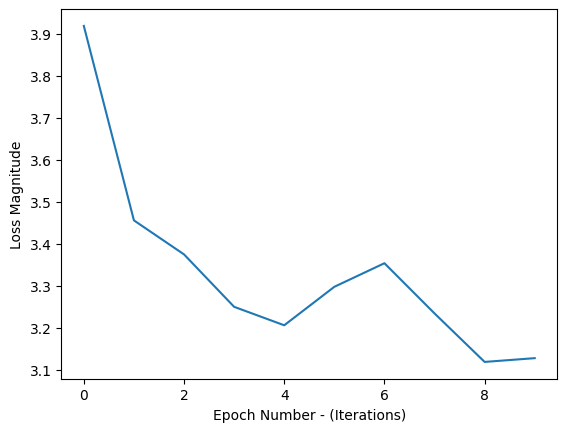

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number - (Iterations)')
plt.ylabel("Loss Magnitude")
plt.plot(history.history['loss'])

In [ ]:
#Predicting the model
def predict_image(model, image_path):
    img = load_and_preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    category_pred, attr_pred = model.predict(img)
    print(f"Predicted Category: {np.argmax(category_pred)}")
    print(f"Predicted Attributes: {np.round(attr_pred)}")

predict_image(model, "img/Sweet_Crochet_Blouse/img_00000070.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Category: 18
Predicted Attributes: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 1.]]
